In [1]:
import pandas as pd

In [147]:
import json
data = {}
with open('homework.json') as f:
    i = 0
    for line in f:
        d = json.loads(line)
        data[i] = d
        i+=1


In [148]:
df = pd.DataFrame.from_dict(data, orient = 'index')
df = df.drop(columns = ['emotion_9'])

In [149]:
df.dtypes

emotion_0    object
emotion_1    object
emotion_2    object
emotion_3    object
emotion_4    object
emotion_5    object
emotion_6    object
emotion_7    object
emotion_8    object
headline     object
summary      object
worker_id    object
dtype: object

In [150]:
df.head()

,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,headline,summary,worker_id
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Parenting Lessons From a Partial Eclipse,I don’t do partiality. Maybe it was finally ti...,95524929
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,On Catalonia,Catalan lawmakers declared independence from S...,30266977
2,0.0,0.0,-2,0.0,0.0,0.0,0.0,0.0,0.0,A Spark of Romance Under Fluorescent Lighting,"Rose Burlingham, an art dealer and writer, mar...",54197764
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,Apple Removes Apps From China Store That Help ...,The world’s most valuable company appears to h...,41177265
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Commerce Secretary’s Offshore Ties to Putin ‘C...,"Wilbur Ross, the commerce secretary, retained ...",56518865


In [157]:
# remove weird boolean rows
df['drop'] = False
for i in range(9):
    df[f'emotion_{i}'] = pd.to_numeric(df[f'emotion_{i}'],errors = 'coerce')
    df.loc[df[f'emotion_{i}'].isin([0.,1.])==False,"drop"] = True

# get rid of dumb text
drops = ["fnord","-1","cat","-2",""]
df.loc[df[f'headline'].isin(drops),"drop"] = True
df.loc[df[f'summary'].isin(drops),"drop"] = True
df = df.loc[df['drop']==False]

#sum ratings on headline-summary level
df2 = df.drop(columns = ["drop","worker_id"]).groupby(["headline","summary"]).sum().reset_index()
sc = df2['summary'].value_counts().reset_index()
summary_drops = list(sc.loc[sc["summary"]>1,"index"]) #only keep single summary-headline
df3 = df2.loc[~df2['summary'].isin(summary_drops)] # remove duplicates

#get modal rating
rename_dic = dict(zip([f"emotion_{x}" for x in range(9)],[x for x in range(9)]))
df3 = df3.rename(columns = rename_dic)
df3['emotion']=df3[[x for x in range(9)]].idxmax(axis=1)

In [158]:

len(df3)

9180

In [154]:
df3.head()

,headline,summary,0,1,2,3,4,5,6,7,8,emotion
0,#MeToo Floods Social Media With Stories of Har...,"Many women, as well as men, are using the hash...",0.0,0.0,0.0,1.0,4.0,2.0,0.0,7.0,2.0,7
1,"$1.3 Million Homes in Oregon, Michigan and Cal...",A Dwell-style home in Portland; a 1929 Tudor h...,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,5.0,8
2,$1.3 Million for That?,Whatever Paul Manafort may or may not have don...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,8
3,"$1.5 Million Homes in California, Montana and ...","A floor-through condominium in San Francisco, ...",2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,8
4,"$1.5 Million Homes in Rhode Island, California...","An 18th-century farmhouse outside Newport, a h...",0.0,0.0,2.0,0.0,1.0,8.0,2.0,0.0,1.0,5


In [95]:
df[df["headline"]=="Right and Left React to the Republican Tax Plan"].head(20)

,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,headline,summary,drop
11519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Right and Left React to the Republican Tax Plan,Writers from across the political spectrum tak...,False
13471,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Right and Left React to the Republican Tax Plan,Writers from across the political spectrum on ...,False
16661,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Right and Left React to the Republican Tax Plan,Writers from across the political spectrum tak...,False
20083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Right and Left React to the Republican Tax Plan,Writers from across the political spectrum on ...,False
21744,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Right and Left React to the Republican Tax Plan,Writers from across the political spectrum on ...,False
25162,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Right and Left React to the Republican Tax Plan,Writers from across the political spectrum tak...,False
25459,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Right and Left React to the Republican Tax Plan,Writers from across the political spectrum on ...,False
29505,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Right and Left React to the Republican Tax Plan,Writers from across the political spectrum tak...,False
49361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Right and Left React to the Republican Tax Plan,Writers from across the political spectrum on ...,False
50454,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Right and Left React to the Republican Tax Plan,Writers from across the political spectrum on ...,False


In [75]:
df.loc[df['summary']== "Suggested reading from critics and editors at The New York Times."].head()

,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,headline,summary,worker_id,drop
113,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10 New Books We Recommend This Week,Suggested reading from critics and editors at ...,45186656,False
936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11 New Books We Recommend This Week,Suggested reading from critics and editors at ...,52060545,False
1418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7 New Books We Recommend This Week,Suggested reading from critics and editors at ...,1075755,False
2329,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10 New Books We Recommend This Week,Suggested reading from critics and editors at ...,47167574,False
2339,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10 New Books We Recommend This Week,Suggested reading from critics and editors at ...,82227559,False


In [58]:
df['headline'].value_counts()

Homes for Sale in New York City                                             189
What to Cook This Weekend                                                   185
                                                                            168
10 New Books We Recommend This Week                                          99
Homes for Sale in New York and New Jersey                                    90
                                                                           ... 
At Benghazi Trial, Harrowing Testimony and Clashing Views of a Defendant      5
Q. and A.: The Cryptic Humanity of Melisandre on ‘Game of Thrones’            5
Kenya Election Result Is Thrown Out                                           5
Emmerson Mnangagwa Urges Zimbabwe’s Robert Mugabe to Resign                   4
Navy Aircraft With 11 Aboard Crashes Into Waters Off Japan                    4
Name: headline, Length: 9262, dtype: int64

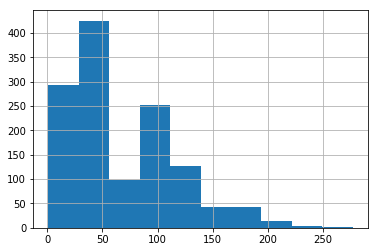

In [51]:
df['worker_id'].value_counts().hist()


In [53]:
for i in range(9):
    print(df[f'emotion_{i}'].value_counts())

0.0    77004
1.0     8258
Name: emotion_0, dtype: int64
0.0    77224
1.0     8038
Name: emotion_1, dtype: int64
0.0    78505
1.0     6757
Name: emotion_2, dtype: int64
0.0    78859
1.0     6403
Name: emotion_3, dtype: int64
0.0    76833
1.0     8429
Name: emotion_4, dtype: int64
0.0    52407
1.0    32855
Name: emotion_5, dtype: int64
0.0    82083
1.0     3179
Name: emotion_6, dtype: int64
0.0    70369
1.0    14893
Name: emotion_7, dtype: int64
0.0    66032
1.0    19230
Name: emotion_8, dtype: int64
